In [1]:
pip install adversarial-robustness-toolbox

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Imports
import keras
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from art.attacks.evasion import FastGradientMethod, BasicIterativeMethod, UniversalPerturbation, SaliencyMapMethod
# from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import KerasClassifier

# Set the random seeds. DO NOT CHANGE THIS!
seedVal = 41
random.seed(seedVal)
np.random.seed(seedVal)

# Defining some constants
NUM_CLASSES = 10
BATCH_SIZE = 64

from tensorflow.python.framework.ops import disable_eager_execution,enable_eager_execution
disable_eager_execution()

## Setting up things

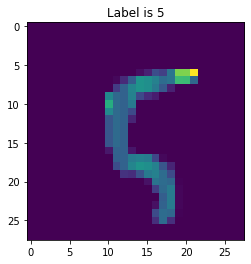

x_train.shape: (60000, 28, 28)


In [3]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalization
x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

# Plot an example image (after normalization) from the train set
plt.title('Label is {}'.format(y_train[100]))
plt.imshow(x_train[100])
plt.show()

print('x_train.shape:',x_train.shape)

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

K.set_image_data_format('channels_first')
x_train = x_train.reshape(x_train.shape[0], 1, 28, 28)
x_test = x_test.reshape(x_test.shape[0], 1, 28, 28)

## Train CNN based model

### You need to complete the following.

In [4]:
# Define the CNN network architecture. 
cnn_based_model = models.Sequential()

# Define the intermediate layers.
cnn_based_model.add(Conv2D(25, (3, 3), activation='relu', padding='valid', input_shape=x_train.shape[1:]))
cnn_based_model.add(MaxPooling2D((3,3)))
cnn_based_model.add(Flatten())
cnn_based_model.add(Dense(NUM_CLASSES, activation='softmax'))
cnn_based_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 26, 26)        250       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 8, 8)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 10)                16010     
                                                                 
Total params: 16,260
Trainable params: 16,260
Non-trainable params: 0
_________________________________________________________________


In [5]:
# Compile the CNN model. 
cnn_based_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

cnn_based_classifier = KerasClassifier(model=cnn_based_model, clip_values=(0,1))
cnn_based_classifier.fit(x_train, y_train, nb_epochs=10, batch_size=BATCH_SIZE)

# Get the predictions on the test set.
predictions = cnn_based_classifier.predict(x_test)
print('prediction:',predictions.shape)


C:\Users\Poorvi Hegde\.conda\envs\mlnn\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 27s 451us/sample - loss: 0.4713 - accuracy: 0.8715
Epoch 2/10
60000/60000 [==============================] - 6s 93us/sample - loss: 0.2022 - accuracy: 0.9426
Epoch 3/10
60000/60000 [==============================] - 6s 92us/sample - loss: 0.1437 - accuracy: 0.9592
Epoch 4/10
60000/60000 [==============================] - 6s 92us/sample - loss: 0.1175 - accuracy: 0.9661
Epoch 5/10
60000/60000 [==============================] - 6s 94us/sample - loss: 0.1017 - accuracy: 0.9706
Epoch 6/10
60000/60000 [==============================] - 6s 97us/sample - loss: 0.0905 - accuracy: 0.9737
Epoch 7/10
60000/60000 [==============================] - 6s 99us/sample - loss: 0.0833 - accuracy: 0.9756
Epoch 8/10
60000/60000 [==============================] - 6s 98us/sample - loss: 0.0769 - accuracy: 0.9782
Epoch 9/10
60000/60000 [==============================] - 6s 98us/sample - loss: 0.0721 - accuracy: 0.9785
Epoch 10/10


C:\Users\Poorvi Hegde\.conda\envs\mlnn\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


prediction: (10000, 10)


In [48]:
y_test_max = []
x_test_max = []
n = len(y_test)
for i in range(0,n):
    y_test_max.append(np.argmax(y_test[i]))
    x_test_max.append(np.argmax(x_test[i]))
y_test_max = np.array(y_test_max)
x_test_max = np.array(x_test_max)

In [49]:
# Compute the accuracy on the test set.
cnn_based_score= cnn_based_model.evaluate(x_test, y_test_max.reshape(10000,1), verbose=True)
print('Test accuracy:', cnn_based_score)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Test accuracy: [0.07317117190975696, 0.9774]


## Train ANN based model (dense layers only)

In [50]:
x_train_reshaped = x_train.reshape(60000,784)
y_train_reshaped = y_train.reshape(60000,10)
x_test_reshaped = x_test.reshape(10000,784)
y_test_reshaped = y_test.reshape(10000,10)

# Define the ANN network architecture.
ann_based_model = Sequential()

# Define the intermediate layers.
ann_based_model.add(Dense(392,activation='relu', input_shape = x_train_reshaped.shape[1:]))
ann_based_model.add(Dense(50,activation='softmax'))
ann_based_model.add(Dropout(0.2))
ann_based_model.add(Dense(NUM_CLASSES, activation='softmax'))
ann_based_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 392)               307720    
                                                                 
 dense_6 (Dense)             (None, 50)                19650     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_7 (Dense)             (None, 10)                510       
                                                                 
Total params: 327,880
Trainable params: 327,880
Non-trainable params: 0
_________________________________________________________________


In [51]:
# Compile the ANN model. 
ann_based_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


In [52]:
ann_based_classifier = KerasClassifier(model=ann_based_model, clip_values=(0,1))
ann_based_classifier.fit(x_train_reshaped, y_train_reshaped, nb_epochs=10, batch_size=BATCH_SIZE)

# Get the predictions on the test set.
predictions = ann_based_classifier.predict(x_test_reshaped)
print('prediction:',predictions.shape)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 58us/sample - loss: 1.5669 - accuracy: 0.6116
Epoch 2/10
60000/60000 [==============================] - 3s 58us/sample - loss: 1.0309 - accuracy: 0.6442
Epoch 3/10
60000/60000 [==============================] - 3s 57us/sample - loss: 0.8668 - accuracy: 0.6554
Epoch 4/10
60000/60000 [==============================] - 4s 59us/sample - loss: 0.7935 - accuracy: 0.6772
Epoch 5/10
60000/60000 [==============================] - 3s 57us/sample - loss: 0.6857 - accuracy: 0.7403
Epoch 6/10
60000/60000 [==============================] - 3s 57us/sample - loss: 0.6357 - accuracy: 0.7638
Epoch 7/10
60000/60000 [==============================] - 3s 58us/sample - loss: 0.5415 - accuracy: 0.8042
Epoch 8/10
60000/60000 [==============================] - 3s 57us/sample - loss: 0.5049 - accuracy: 0.8116
Epoch 9/10
60000/60000 [==============================] - 3s 58us/sample - loss: 0.4775 - accuracy: 0.8137
Epoch 10/10
60

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


prediction: (10000, 10)


In [53]:
x_test_reshaped = x_test.reshape(10000,784)

# Compute the accuracy on the test set.
ann_score = ann_based_model.evaluate(x_test_reshaped, y_test_max.reshape(10000,1), verbose=True)
print('Test accuracy:', ann_score)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Test accuracy: [0.1325748831629753, 0.9747]


## Compare the classification accuracy on the test data graphically

### You need to complete the following.

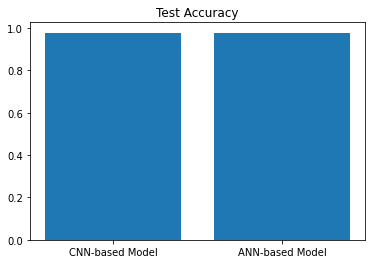

In [54]:
X = ['CNN-based Model','ANN-based Model']
Y = [cnn_based_score, ann_score]
plt.bar(X,[Y[0][1],Y[1][1]])
plt.title('Test Accuracy')
plt.show()
plt.close()

## Part 2: Generate adversarial examples using four methods

### You need to complete the following.

In [55]:
def generate_adv_examples_FGSM(classifier, x):
    # This attack is known as the "Fast Gradient Sign Method".
    attack = FastGradientMethod(classifier)
    return attack.generate(x)

def generate_adv_examples_BasicIterativeMethod(classifier, x):
    # The Basic Iterative Method is the iterative version of FGM and FGSM.
    attack = BasicIterativeMethod(classifier,verbose=False)
    return attack.generate(x)

def generate_adv_examples_SaliencyMapMethod(classifier, x):
    # attack from the Jacobian-based Saliency Map Attack (Papernot et al. 2016).
    # Paper link: https://arxiv.org/abs/1511.07528
    attack = SaliencyMapMethod(classifier,verbose=False)
    return attack.generate(x)

def generate_adv_examples_UniversalPerturbation(classifier, x):
    attack = UniversalPerturbation(classifier,verbose=False)
    return attack.generate(x)

In [56]:
x_input = []
for i in range(0,8):
    x_input.append(x_test[np.random.randint(10000)])
x_input = np.asarray(x_input)

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

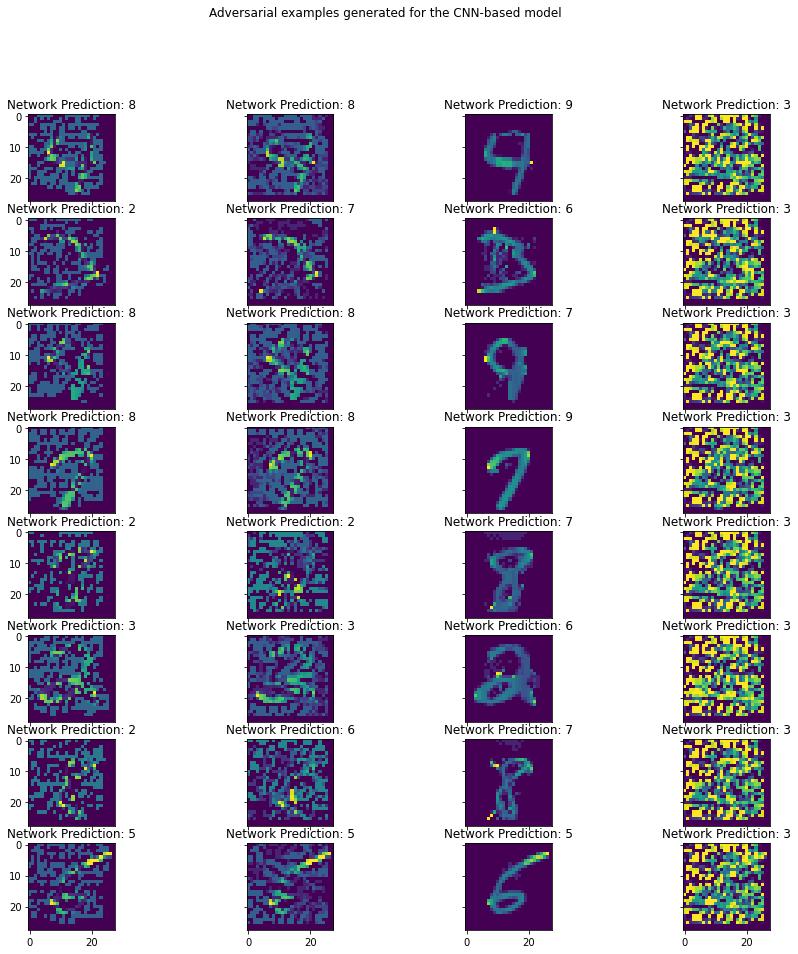

In [57]:
# Generate examples for CNN-based model
cnn_adv_examples=[]
cnn_adv_examples.append(generate_adv_examples_FGSM(cnn_based_classifier,x_input[0:8]))
cnn_adv_examples.append(generate_adv_examples_BasicIterativeMethod(cnn_based_classifier,x_input[0:8]))
cnn_adv_examples.append(generate_adv_examples_SaliencyMapMethod(cnn_based_classifier,x_input[0:8]))
cnn_adv_examples.append(generate_adv_examples_UniversalPerturbation(cnn_based_classifier,x_input[0:8]))


# Generate plot
fig, ax = plt.subplots(8, 4, sharex='col', sharey='row', figsize=(15,15))
fig.suptitle('Adversarial examples generated for the CNN-based model')

for i in range(8):
    for j in range(4):
        ax[i, j].imshow(cnn_adv_examples[j][i].squeeze())
        predictions = cnn_based_classifier.predict(np.expand_dims(cnn_adv_examples[j][i], 0))
        ax[i, j].set_title('Network Prediction: {}'.format(np.argmax(predictions)))

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

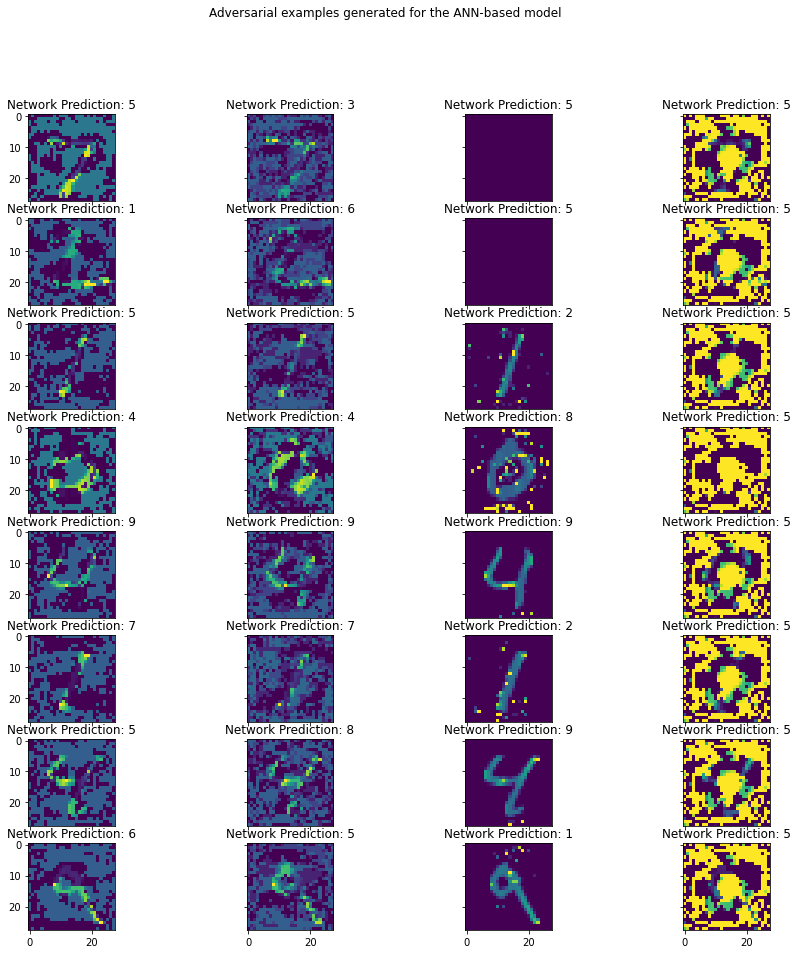

In [58]:
x_input = x_input.reshape(8,784)
# Generate examples for ANN-based model
ann_adv_examples=[]
ann_adv_examples.append(generate_adv_examples_FGSM(ann_based_classifier,x_test_reshaped[0:8]))
ann_adv_examples.append(generate_adv_examples_BasicIterativeMethod(ann_based_classifier,x_test_reshaped[0:8]))
ann_adv_examples.append(generate_adv_examples_SaliencyMapMethod(ann_based_classifier,x_test_reshaped[0:8]))
ann_adv_examples.append(generate_adv_examples_UniversalPerturbation(ann_based_classifier,x_test_reshaped[0:8]))

# Generate plots
fig, ax = plt.subplots(8, 4, sharex='col', sharey='row', figsize=(15,15))
fig.suptitle('Adversarial examples generated for the ANN-based model')

for i in range(8):
    for j in range(4):
        ax[i, j].imshow(ann_adv_examples[j][i].reshape(28,28).squeeze())
        predictions = ann_based_classifier.predict(np.expand_dims(ann_adv_examples[j][i], 0))
        ax[i, j].set_title('Network Prediction: {}'.format(np.argmax(predictions)))

## Part 3: Create a new test set, based entirely on the adversarial images generated previously. Test your classifiers performance on this test set.

### You need to complete the following.

In [59]:
# We will be using the FGSM method in this part
ann_adv_examples_FGSM = generate_adv_examples_FGSM(ann_based_classifier,x_test_reshaped)
cnn_adv_examples_FGSM = generate_adv_examples_FGSM(cnn_based_classifier,x_test)

In [61]:
# Evaluate ANN-based-classifier on the newly generated adversarial test set
predictions = ann_based_model.predict(ann_adv_examples_FGSM)
ann_adversarial_score = ann_based_model.evaluate(ann_adv_examples_FGSM, y_test_max.reshape(10000,1))
print('ANN-based Model Score: {}'.format(ann_adversarial_score))

ANN-based Model Score: [5.807975007629395, 0.0102]


In [62]:
# Evaluate CNN-based-classifier on the newly generated adversarial test set
predictions = cnn_based_classifier.predict(cnn_adv_examples_FGSM)
cnn_adversarial_score = cnn_based_model.evaluate(cnn_adv_examples_FGSM, y_test_max.reshape(10000,1), BATCH_SIZE, verbose=1)
print('CNN-based Model Score: {}'.format(cnn_adversarial_score))

CNN-based Model Score: [31.89901357421875, 0.0193]


## Create a new augmented test set (original test images + adversarial images)


### You need to complete the following.

In [63]:
# ANN-based-classifier
ann_augmented_examples = []
for i in range(10000):
    
    # Select adversarial samples.
    if random.randint(0, 1) == 0:
        ann_augmented_examples.append(ann_adv_examples_FGSM[i])
    # Select actual samples.
    else:
        ann_augmented_examples.append(x_test_reshaped[i])
      

In [64]:
ann_augmented_examples = np.asarray(ann_augmented_examples)
ann_augmented_examples.shape

(10000, 784)

In [65]:
# ann_augmented_examples = np.concatenate(ann_augmented_examples, axis=0)
predictions = ann_based_classifier.predict(ann_augmented_examples)
ann_augmented_score = ann_based_model.evaluate(ann_augmented_examples, y_test_max.reshape(10000,1), BATCH_SIZE, verbose=1)
print('ANN-based Model Score: {}'.format(ann_augmented_score))

ANN-based Model Score: [2.9833102653503416, 0.4912]


In [66]:
# CNN-based-classifier
cnn_augmented_examples = []
for i in range(10000):
    
    # Select adversarial samples.
    if random.randint(0, 1) == 0:
        cnn_augmented_examples.append(cnn_adv_examples_FGSM[i])
    # Select actual samples.
    else:
        cnn_augmented_examples.append(x_test[i])

In [67]:
cnn_augmented_examples = np.asarray(cnn_augmented_examples)
cnn_augmented_examples.shape

(10000, 1, 28, 28)

In [68]:
# cnn_augmented_examples = np.concatenate(cnn_augmented_examples, axis=0)
predictions = cnn_based_classifier.predict(cnn_augmented_examples)

In [69]:
cnn_augmented_score = cnn_based_model.evaluate(cnn_augmented_examples, y_test_max.reshape(10000,1), BATCH_SIZE, verbose=1)
print('CNN-based Model Score: {}'.format(cnn_based_score))

CNN-based Model Score: [0.07317117190975696, 0.9774]


## Make a single plot, wherein you compare the test accuracies of all the models, on the three types of test sets that you have

### You need to complete the following.

In [70]:
ann_models_score = ann_augmented_score
cnn_models_score = cnn_augmented_score

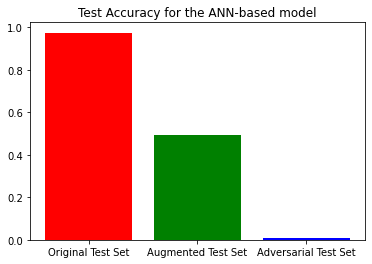

In [71]:
# Plot for the ANN based model.
X = ['Original Test Set','Augmented Test Set', 'Adversarial Test Set']
Y = [ann_score[1],ann_augmented_score[1],ann_adversarial_score[1]]
plt.bar(X,Y, color=['r', 'g', 'b'])
plt.title('Test Accuracy for the ANN-based model')
plt.show()
plt.close()

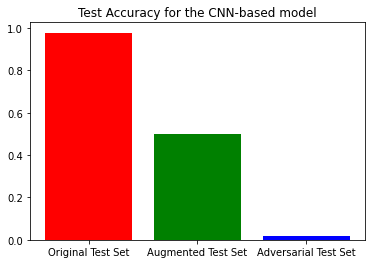

In [72]:
# Plot for the CNN based model.
X = ['Original Test Set','Augmented Test Set', 'Adversarial Test Set']
Y = [cnn_based_score[1],cnn_augmented_score[1],cnn_adversarial_score[1]]
plt.bar(X,Y, color=['r', 'g', 'b'])
plt.title('Test Accuracy for the CNN-based model')
plt.show()
plt.close()